In [1]:
import os
import numpy as np
import sympy as sy
import math

import matplotlib.pyplot as plt

import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app

import openmmtools as mmtools
from openmmtools import testsystems

import yank.repex as repex
import yank.analyze as analyze

import tempfile

plt.style.use("ggplot")

---------------

# System Definition (3D Double Well Potential)

In [2]:
# One particle in 3D
system = mm.System()
mass = 1.0 * unit.amu 
system.addParticle(mass)

0

### Y and Z dimensions: Harmonic Well

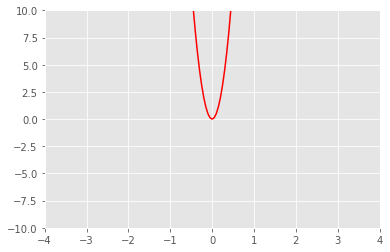

In [3]:
# '0.5*K*x**2'

def harmonic_well(x,K):
    return 0.5*K*x**2

K=100.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, harmonic_well(x_serie,K), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()

In [4]:
x = sy.symbols('x')
g=sy.diff(0.5*K*x**2,x)
gg=sy.diff(0.5*K*x**2,x,x)
roots_diff=sy.roots(g,x)
roots_yz=list(roots_diff.keys())

In [5]:
# Period:
print("Oscillation periods T in minima:")
for root in roots_diff.keys():
    freq=gg.subs(x,root)
    if freq>0:
        print(2*np.pi*np.sqrt(mass._value/float(freq)))

Oscillation periods T in minima:
0.6283185307179586


### X dimension: Double Well

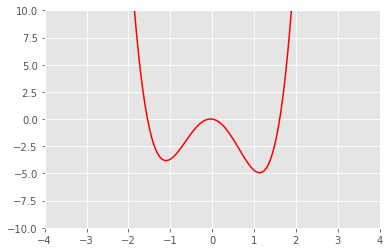

In [6]:
# 'Eo(C*x**4-x**2)+M*x'

def double_well(x,Eo,C,M):
    return Eo*(C*x**4-x**2)+M*x

Eo=7.0
C=0.4
M=-0.5

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, double_well(x_serie,Eo,C,M), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()

In [7]:
x = sy.symbols('x')
g=sy.diff(Eo*(C*x**4-x**2)+M*x,x)
gg=sy.diff(Eo*(C*x**4-x**2)+M*x,x,x)
roots_diff=sy.roots(g,x)
roots_x=list(roots_diff.keys())

In [8]:
# Period:
print("Oscillation periods T in minima:")
for root in list(roots_diff.keys()):
    freq=gg.subs(x,root)
    try:
        if freq>0:
            print(np.sqrt(float(freq)/mass._value))
    except:
        print("Not real frequency found")
        
## Tengo que calcular aqui las dos barreras

Oscillation periods T in minima:
5.161010422764949
5.414889333675711


## Adding potential to the system

In [9]:
K  = K  * unit.kilocalories_per_mole/unit.angstrom**2
Eo = Eo * unit.kilocalories_per_mole/unit.angstrom**2
C  = C  * 1/unit.angstrom**2
M  = M  * unit.kilocalories_per_mole/unit.angstrom

force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
force.addGlobalParameter('K', K)
force.addGlobalParameter('Eo', Eo)
force.addGlobalParameter('C', C)
force.addGlobalParameter('M', M)
force.addParticle(0, [])
system.addForce(force)

0

## Initial Conditions

In [10]:
position_minimum=np.array([[roots_x[0],roots_yz[0],roots_yz[0]]],dtype=float)
initial_positions = unit.Quantity(position_minimum, unit.angstroms)
system.positions = initial_positions
# velocities?? should be randomly generated according to the maxwell-boltzmann distribution 

----------------

# Simulation Options

In [11]:
platform_name='CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)


#kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA

# Parallel Tempering Parameters

In [12]:
n_replicas = 8
T_min      = 300.0*unit.kelvin
T_max      = 600.0*unit.kelvin

temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0) 
                for i in range(n_replicas)]

print(temperatures)

[Quantity(value=300.0, unit=kelvin), Quantity(value=326.81137500583793, unit=kelvin), Quantity(value=357.7400386775781, unit=kelvin), Quantity(value=393.41826242818166, unit=kelvin), Quantity(value=434.5754124269132, unit=kelvin), Quantity(value=482.052859955097, unit=kelvin), Quantity(value=536.8211814705792, unit=kelvin), Quantity(value=600.0, unit=kelvin)]


# Thermodynamic States Definition

In [13]:
thermodynamic_states = [mmtools.states.ThermodynamicState(system=system, temperature=T) for T in temperatures]

# REPEX Options

In [14]:
move = repex.mmtools.mcmc.GHMCMove(timestep=2.0*unit.femtoseconds, n_steps=50)
simulation = repex.ReplicaExchange(mcmc_moves=move, number_of_iterations=1000)

# Reporter

In [17]:
#storage_path = tempfile.NamedTemporaryFile(delete=False).name+'.nc'
#print(storage_path)
storage_path = '/home/diego/Projects/REMD/REMD_T/prueba.nc'
os.remove(storage_path)
reporter = repex.Reporter(storage_path, checkpoint_interval=1)

# Running REPEX Simulation

In [18]:
simulation._have_displayed_citations_before=True
simulation.create(thermodynamic_states=thermodynamic_states,
                  sampler_states=mmtools.states.SamplerState(system.positions),
                  storage=reporter)

In [19]:
simulation.run()

In [20]:
print(simulation.iteration)

1000


In [23]:
total_number_iterations_run=200*50*n_replicas*1000
print(total_number_iterations_run)

80000000


In [22]:
#print(reporter.is_open())
reporter.close()
del reporter

True
